In [1]:
from datasets import PascalVOC
from torchvision import transforms
from utils import recover_wh_bboxes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import plot_with_targets
from torch.autograd import Variable
from models import RegionProposalNetwork, BaseCNN

In [2]:
path =  '/home/austin/data/VOC/VOC2007/'

In [3]:
trans = transforms.Compose([transforms.Scale(600), transforms.ToTensor()])
voc = PascalVOC(root=path, transform=trans)


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


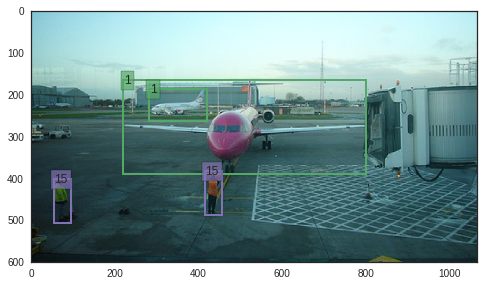

In [4]:
test_idx = 4
img, target = voc[test_idx]
plot_with_targets(img, target)

In [5]:
basecnn = BaseCNN()

In [6]:
features = basecnn(Variable(img.unsqueeze(0)))

In [7]:
img.size()

torch.Size([3, 600, 1067])

In [8]:
features.size()

torch.Size([1, 512, 37, 66])

In [9]:
rpn = RegionProposalNetwork()

In [10]:
anchor_boxes = rpn.get_anchor_boxes(features)

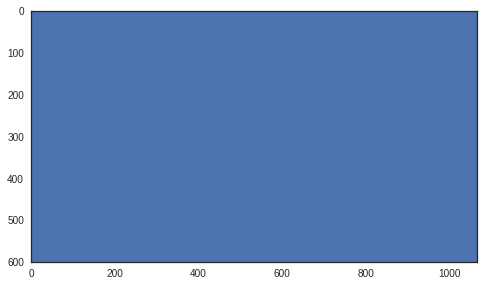

In [11]:
plot_with_targets(img, anchor_boxes)

In [12]:
rpn_cls_probs, rpn_bbox_deltas = rpn(features)

In [13]:
rpn_bbox_deltas.size()

torch.Size([21978, 4])

## assign positive to boxes with iou > 0.7 or the highest iou with any gt box

In [14]:
from utils import get_overlaps

In [15]:
overlaps = get_overlaps(anchor_boxes, target)

In [16]:
labels = rpn.get_anchor_box_labels(overlaps)

In [17]:
labels[labels==1].shape, labels[labels==0].shape, labels[labels==-1].shape

((1,), (21977,), (0,))

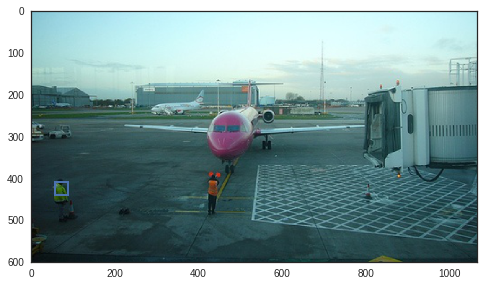

In [18]:
plot_with_targets(img, anchor_boxes[labels==1])

In [19]:
rpn_bbox_deltas[:, 0]

Variable containing:
-9.3976e-02
 2.5409e-02
-8.5779e-02
     ⋮     
 1.0624e-02
 4.2201e-02
 7.1207e-02
[torch.FloatTensor of size 21978]

In [20]:
rpn_labels, bbox_targets, keep = rpn.get_rpn_targets(target)

In [21]:
bbox_targets.shape, rpn_labels.shape

(torch.Size([256, 4]), torch.Size([256]))

## ignore cross boundary boxes only during training

In [22]:
rpn_cls_probs, rpn_bbox_deltas

(Variable containing:
 -1.6885e-02  4.1618e-02
 -1.3009e-01  1.2779e-04
  1.8171e-02  6.8871e-02
            ⋮            
 -3.2953e-02  2.9999e-02
 -7.9085e-02 -8.7953e-02
  4.2585e-02 -2.7473e-02
 [torch.FloatTensor of size 21978x2], Variable containing:
 -9.3976e-02 -5.8771e-03  1.2747e-01 -8.0810e-02
  2.5409e-02  6.0866e-02  2.4567e-02  6.1217e-02
 -8.5779e-02 -2.3940e-02 -3.8888e-03 -3.4093e-02
                        ⋮                        
  1.0624e-02  5.9102e-02 -7.2253e-02  3.4817e-02
  4.2201e-02  7.3701e-02  3.9241e-02  3.7232e-02
  7.1207e-02 -2.7364e-02  1.1835e-02  1.2938e-02
 [torch.FloatTensor of size 21978x4])

In [23]:
import torch.nn.functional as F

In [24]:
F.smooth_l1_loss(rpn_bbox_deltas[keep], Variable(bbox_targets))

Variable containing:
 8.7796
[torch.FloatTensor of size 1]

In [25]:
F.cross_entropy(rpn_cls_probs[keep], Variable(rpn_labels))

Variable containing:
 0.7025
[torch.FloatTensor of size 1]

In [26]:
bbox_targets


  0.0364   0.9388   0.2616   1.2136
  2.3638  14.8075   3.5935   2.6533
-17.5808  18.1533   3.9238   3.6341
                 ⋮                  
 -1.9173  -3.7064   3.2751   1.6417
  7.2096 -20.2567   3.2306   2.9409
 59.2401  -6.0982   4.6613   3.0280
[torch.FloatTensor of size 256x4]

In [27]:
rpn_cls_probs.data.cpu().numpy()[:, 1]

array([ 0.04161788,  0.00012779,  0.06887065, ...,  0.0299992 ,
       -0.08795302, -0.02747312], dtype=float32)

In [28]:
anchor_boxes

array([[    3.25,     6.  ,    13.75,    11.  ],
       [   -2.5 ,     3.  ,    19.5 ,    14.  ],
       [  -14.  ,    -3.  ,    31.  ,    20.  ],
       ..., 
       [ 1046.25,   579.5 ,  1050.75,   589.5 ],
       [ 1043.5 ,   574.  ,  1053.5 ,   595.  ],
       [ 1038.  ,   563.  ,  1059.  ,   606.  ]])

In [29]:
rpn_bbox_deltas

Variable containing:
-9.3976e-02 -5.8771e-03  1.2747e-01 -8.0810e-02
 2.5409e-02  6.0866e-02  2.4567e-02  6.1217e-02
-8.5779e-02 -2.3940e-02 -3.8888e-03 -3.4093e-02
                       ⋮                        
 1.0624e-02  5.9102e-02 -7.2253e-02  3.4817e-02
 4.2201e-02  7.3701e-02  3.9241e-02  3.7232e-02
 7.1207e-02 -2.7364e-02  1.1835e-02  1.2938e-02
[torch.FloatTensor of size 21978x4]

In [30]:
features.size()

torch.Size([1, 512, 37, 66])

In [31]:
rpn_cls_probs

Variable containing:
-1.6885e-02  4.1618e-02
-1.3009e-01  1.2779e-04
 1.8171e-02  6.8871e-02
           ⋮            
-3.2953e-02  2.9999e-02
-7.9085e-02 -8.7953e-02
 4.2585e-02 -2.7473e-02
[torch.FloatTensor of size 21978x2]

In [32]:
proposal_boxes, scores = rpn.get_proposal_boxes(rpn_bbox_deltas, rpn_cls_probs)

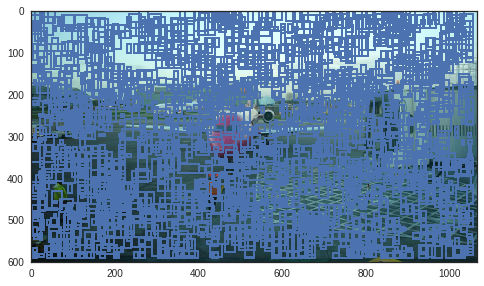

In [33]:
plot_with_targets(img, proposal_boxes)

In [34]:
proposal_boxes.shape

(2000, 4)

In [35]:
proposal_boxes, scores

(array([[ 149.30740356,   85.83518219,  157.39598083,   94.46407318],
        [ 489.4909668 ,  344.39025879,  518.58221436,  375.98309326],
        [ 770.35009766,  416.02340698,  786.06945801,  432.56655884],
        ..., 
        [ 490.16000366,  236.94139099,  521.67218018,  266.77444458],
        [  27.77353668,  383.8298645 ,   75.89874268,  406.69329834],
        [ 623.6541748 ,  353.10290527,  645.84002686,  394.93826294]], dtype=float32),
 array([-0.04391386, -0.0439146 , -0.04392982, ..., -0.06586811,
        -0.06587007, -0.06588237], dtype=float32))

In [36]:
from models import Classifier

In [37]:
classifier = Classifier()

In [38]:
labels, delta_boxes, batch_indexes = classifier.get_targets(proposal_boxes, target)

In [39]:
labels.size()

torch.Size([96])

In [40]:
delta_boxes.size()

torch.Size([96, 4])

In [41]:
pred_label, pred_bbox_deltas = classifier(features, proposal_boxes)

In [42]:
pred_label, pred_bbox_deltas

(Variable containing:
  1.0675e-01  3.0493e-03  4.0920e-02  ...   1.3956e-02 -1.3099e-02  1.4838e-01
  3.6855e-02 -8.3611e-02  2.5524e-02  ...   5.4405e-02 -1.4915e-01  4.7694e-02
  2.0712e-02  6.2772e-02  2.1757e-01  ...   7.8330e-02 -1.6843e-01  5.7904e-02
                 ...                   ⋱                   ...                
  1.1093e-02  1.1643e-01 -3.2318e-02  ...   1.2739e-01 -1.7772e-01 -1.0807e-01
 -1.2526e-01 -2.3738e-03 -2.3149e-02  ...   1.0048e-03 -3.1413e-02  3.6344e-02
 -3.3289e-02  3.6218e-02  3.9121e-03  ...   2.7909e-02  9.8731e-03  3.2008e-02
 [torch.FloatTensor of size 2000x21], Variable containing:
 ( 0  ,.,.) = 
   2.4412e-02  8.1934e-02  3.4371e-02 -7.0243e-02
  -6.7686e-02  4.8340e-02 -1.9393e-02 -4.1309e-02
  -2.8184e-02 -9.8008e-02  3.6575e-02 -8.0737e-02
                        ⋮                        
  -4.9518e-02  2.8963e-02  1.5031e-02  2.6833e-02
   5.4269e-02  4.2574e-02  5.4146e-02  8.8648e-02
   1.3143e-02  5.6216e-02 -2.2351e-02 -3.5733e-02
 

In [43]:
import torch

In [44]:
len(proposal_boxes)

2000

In [45]:
torch.max(batch_indexes)

1992

In [46]:
pred_bbox_deltas[batch_indexes]

Variable containing:
(0 ,.,.) = 
  2.7738e-02 -5.9454e-03 -1.7995e-02 -1.5372e-02
 -7.2329e-02  3.8295e-02  3.0546e-02 -1.8327e-03
  7.3382e-02 -1.2421e-01  8.6253e-02  3.4867e-02
                       ⋮                        
  6.4784e-03 -1.7784e-03  2.1871e-02 -1.9609e-02
 -2.0295e-02  1.4897e-03  2.3146e-02  1.7456e-02
  1.7909e-02 -3.8833e-02  4.7702e-02 -5.7308e-02

(1 ,.,.) = 
  1.5440e-02  5.5248e-02  2.4790e-02 -5.0613e-03
 -1.4209e-02  9.9904e-02  8.1677e-03 -6.5728e-04
 -2.5326e-03 -3.0919e-03  7.3916e-02 -6.6407e-02
                       ⋮                        
 -8.4382e-03  8.0468e-02  1.9702e-03 -3.9174e-02
  1.0431e-02  1.3950e-02  2.2197e-02 -3.6085e-02
 -4.4583e-02 -6.9947e-02 -6.9192e-02  3.4237e-02

(2 ,.,.) = 
  1.8442e-02  6.9803e-03  4.8888e-02  1.0260e-01
 -4.5298e-02  5.9377e-02 -2.6731e-02  3.0790e-02
 -2.6956e-02 -1.5003e-02  5.0083e-03  2.9264e-03
                       ⋮                        
  5.6164e-02  4.5298e-02  3.4986e-03  3.4956e-02
  3.0906e-

In [47]:
pred_bbox_deltas = pred_bbox_deltas.view(-1, 21, 4)

In [48]:
F.smooth_l1_loss(pred_bbox_deltas[batch_indexes, labels, :], Variable(delta_boxes))

Variable containing:
 7.7927
[torch.FloatTensor of size 1]

In [49]:
F.cross_entropy(pred_label[batch_indexes], Variable(labels))

Variable containing:
 3.0631
[torch.FloatTensor of size 1]

In [50]:
from models import FasterRCNN

In [51]:
frcnn = FasterRCNN(basecnn, rpn, classifier)

In [52]:
rpn_cls_probs, rpn_bbox_deltas, pred_label, pred_bbox_deltas = frcnn(Variable(img.unsqueeze(0)))

In [53]:
rpn_labels, rpn_bbox_targets, rpn_batch_indices = frcnn.get_rpn_targets(target)

In [54]:
classifier_labels, delta_boxes, clf_batch_indices = frcnn.get_classifier_targets(target)

In [ ]:
rpn_labels.size()